# 310 ML Eng. Challenge - Task 2 - Masked Language Modelling

- **Task specification**:
    - Masked Language Modelling
    - Datacet: WikiText2
    - Metric: perplexity
 
---

- **Approach**:
    - Framework: PyTorch
    - Model used: Transformer (Encoder-only)

In [1]:
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset, DataLoader

In [2]:
%matplotlib inline

In [3]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [4]:
class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output


def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

# 2- Change the task from autoregressive to predict the masked words. You can mask 10% of the words at random.

## Load and batch data




In [5]:
%%bash
pip install torchdata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


>> Here we define the **`Dataset` module for MLM task**, were sequences in a dataset are processed into **(input, label, attention_mask)** to match the Masked LM task.

>> The key part to changing the original code in the challenge to MLM task is here.

In [6]:
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')
specials = ['<unk>','[PAD]','[MASK]','[EOS]']
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=specials)
vocab.set_default_index(vocab['<unk>']) 

# Define the masked language modeling task dataset
class MaskedLMDataset(torch.utils.data.Dataset):
    def __init__(self, data_iter, tokenizer, vocab, seq_len, min_seq_len=4, mask_pct=0.1):
        self.data_iter = data_iter
        self.dataset = [tokenizer(item) for item in data_iter if len(tokenizer(item))>=min_seq_len]
        self.tokenizer = tokenizer
        self.vocab = vocab
        self.seq_len = seq_len
        self.mask_pct = mask_pct

    def __len__(self):
        return(len(self.dataset))

    def __getitem__(self, index):
        """
        retrieves sequence from the dataset and returns it to be processes by the Masked Language Model.

        Inputs:
        -------
            index [int]: index of the corresponding sequence from the dataset
        
        Returns:
        -------
            masked_tokens [torch.Tensor]: tensor of token indicies of the masked sentence.
                used as transformer inputes
            labels [torch.Tensor]: tensor of token indicies of only masked tokens
                (unmasked tokens get the value of -100). used as transformer labels
            attention_mask: src_mask for Transformer layer input.
                seq_len by seq_len square tensor with float(-inf) as upper tri values
                and zeros elsewhere.
        
        """
        tokens = self.dataset[index]
        token_idx = [self.vocab[token] for token in tokens] + [self.vocab['[EOS]']]

        # Mask 10% of the tokens
        masked_tokens = token_idx.copy()
        unmasked_tokens = token_idx.copy()
        num_masked = max(1, int(len(tokens) * self.mask_pct))
        masked_indices = torch.randperm(len(tokens))[:num_masked]
        for i in masked_indices:
            if token_idx[i] == self.vocab['[EOS]']:
                continue
            masked_tokens[i] = self.vocab['[MASK]']

            # original MLM replaces %20 of the mased tokens with random other tokens instead of mask token
            # if torch.rand(1) < 0.8:
            #     masked_tokens[i] = self.vocab['[MASK]']
            # elif torch.rand(1) < 0.5:
            #     masked_tokens[i] = torch.randint(len(self.vocab), (1,)).item()

        attention_mask = get_attn_sqr_mask(self.seq_len)

        # Pad or truncate the sequence
        if len(token_idx) < self.seq_len:
            unmasked_tokens = unmasked_tokens + [self.vocab['[PAD]']] * (self.seq_len - len(token_idx))
            masked_tokens = masked_tokens + [self.vocab['[PAD]']] * (self.seq_len - len(token_idx))
            # prevents transformer layers to attend to padded tokens
            attention_mask[:,len(token_idx):] = float('-inf')
        else:
            unmasked_tokens = unmasked_tokens[:self.seq_len]
            masked_tokens = masked_tokens[:self.seq_len]

        # create final input and label sequence tensors
        masked_tokens = torch.tensor(masked_tokens) 
        labels = torch.tensor(unmasked_tokens).clone()
        labels[masked_tokens != self.vocab['[MASK]']] = -100 # only calculate loss on masked tokens

        return masked_tokens, labels, attention_mask


    def generate_from_custom_sentece(self, sent: str, mask_idx=None, pad_or_trunc=False):
        """
        function to prepare any arbitrary sentence string to be processes by the Masked Language Model.

        Inputs:
        -------
            sent [str]: complete sample string to perform masking on and generate
                masked_tokens, labels, attention_mask from
            mask_idx [Iterable]: sequence of indicies to be masked
            pad_or_trunc[Boolean]: wether to perform padding/truncation to the 
                input.
        
        Returns:
        -------
            masked_tokens [torch.Tensor]: tensor of token indicies of the masked sentence.
                used as transformer inputes
            labels [torch.Tensor]: tensor of token indicies of only masked tokens
                (unmasked tokens get the value of -100). used as transformer labels
            attention_mask: src_mask for Transformer layer input.
                seq_len by seq_len square tensor with float(-inf) as upper tri values
                and zeros elsewhere.
        
        """
        tokens = self.tokenizer(sent)
        unmasked_token_ids = [self.vocab[token] for token in tokens] + [self.vocab['[EOS]']]
        masked_token_ids = unmasked_token_ids.copy()
        for idx in mask_idx:
            masked_token_ids[idx] = self.vocab['[MASK]']
        attention_mask = get_attn_sqr_mask(self.seq_len)
        if pad_or_trunc:
                # Pad or truncate the sequence
            if len(masked_token_ids) < self.seq_len:
                unmasked_tokens = unmasked_tokens + [self.vocab['[PAD]']] * (self.seq_len - len(tokens)+1)
                masked_tokens = masked_tokens + [self.vocab['[PAD]']] * (self.seq_len - len(tokens)+1)
                # prevents transformer layers to attend to padded tokens
                attention_mask[:,len(tokens)+1:] = float('-inf')
            else:
                unmasked_tokens = unmasked_tokens[:self.seq_len]
                masked_tokens = masked_tokens[:self.seq_len]

        # create final input and label sequence tensors
        masked_tokens = torch.tensor(masked_tokens) 
        labels = torch.tensor(unmasked_tokens).clone()
        labels[masked_tokens != self.vocab['[MASK]']] = -100 # only calculate loss on masked tokens

        return masked_tokens, labels, attention_mask

In [7]:
def get_attn_sqr_mask(seq_len: int):
    attention_mask = torch.triu(torch.ones(seq_len, seq_len) * float('-inf'), diagonal=1)
    return(attention_mask)

### Functions to generate input and target sequence




In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 20
eval_batch_size = 10
seq_len = 128

# Prepare the dataset
train_iter, valid_iter, test_iter = WikiText2(root='./data')
# the `min_seq_len` parameter prevents sentences shorter than min_seq_len value to be in the dataset
# it results in less sparse data and provide more information to the model
train_dataset = MaskedLMDataset(train_iter, tokenizer, vocab, seq_len, min_seq_len=2)
valid_dataset = MaskedLMDataset(valid_iter, tokenizer, vocab, seq_len, min_seq_len=2)
test_dataset = MaskedLMDataset(test_iter, tokenizer, vocab, seq_len, min_seq_len=2)

# Prepare the data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=eval_batch_size)
test_loader = DataLoader(test_dataset, batch_size=eval_batch_size)


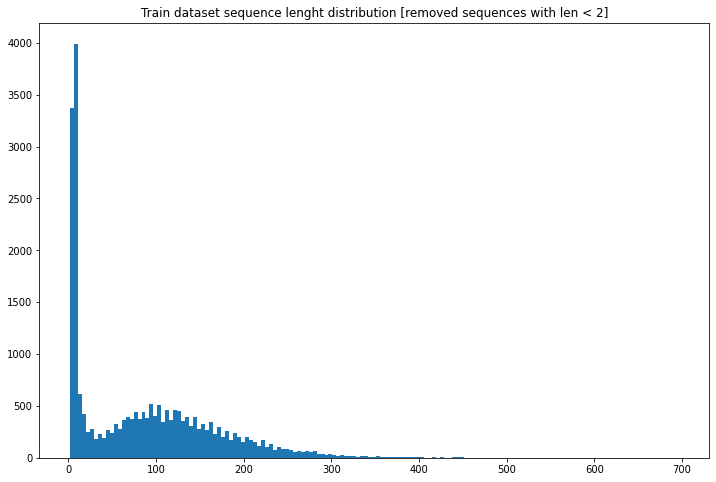

In [25]:

import matplotlib.pyplot as plt

lens = [len(seq) for seq in train_dataset.dataset]
plt.figure(figsize=(12,8))
plt.hist(lens, bins=int(len(lens)**0.5))
plt.title("Train dataset sequence lenght distribution [removed sequences with len < 2]");


In [26]:
import pandas as pd
zeros = [x for x in lens if x==0]
print("num empty sequences =", len(zeros))
print(pd.Series(lens).describe())

num empty sequences = 0
count    23621.000000
mean        86.780577
std         81.513111
min          2.000000
25%          8.000000
50%         75.000000
75%        139.000000
max        696.000000
dtype: float64


In [ ]:
# This block is for testing input/output shapes and model behaviour and debugging
# for inputs, targets, attention_mask in train_loader:
#     out = model(inputs.permute(1,0), torch.triu(torch.ones((seq_len, seq_len))* float('-inf'), diagonal=1))
#     # print(model.encoder(inputs.permute(0,1)))
#     # print(inputs.permute(1,0))
#     # print(out.permute(1, 2, 0))
    # break

torch.Size([148])


# 3- Define a reasonable baseline and compare model performance with that.

>> For the baseline model, the `min_seq` parameter of the dataset is set to 2, so it prevents empty and single-word sequences from pasing into the model.

>> This parameter can be optimized as a part of improving the model without extra resources.

## Initiate an instance




The model hyperparameters are defined below. The vocab size is
equal to the length of the vocab object.




In [27]:
ntokens = len(vocab)  # size of vocabulary
emsize = 200  # embedding dimension
d_hid = 200  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # number of heads in nn.MultiheadAttention
dropout = 0.2  # dropout probability
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)

## Run the model




We use [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)_
with the [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)_
(stochastic gradient descent) optimizer. The learning rate is initially set to
0.05 and follows a [StepLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html)_
schedule. During training, we use [nn.utils.clip_grad_norm\_](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html)_
to prevent gradients from exploding.




In [28]:
import copy
import time

def train(model: nn.Module) -> None:

    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 200
    start_time = time.time()
    # src_mask = generate_square_subsequent_mask(bptt).to(device)

    num_batches = len(train_loader)
    for batch, (inputs, targets, attention_mask) in enumerate(train_loader):
        
        inputs = inputs.permute(1,0).to(device)
        targets = targets.to(device)
        attention_mask = attention_mask[0,...].to(device)
        optimizer.zero_grad()
        logits = model(inputs, attention_mask)

        # for calculaing loss we shoul have following shapes: logits -> size:(batch_size, num_classes, seq_len) | targets-> size:(Batchsize, seq_len)
        loss = criterion(logits.permute(1,2,0), targets) 
        # loss = criterion(logits.view(-1, len(vocab)), targets.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / (batch+1)
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.4f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            # total_loss = 0
            start_time = time.time()
    return(total_loss/num_batches)

def evaluate(model: nn.Module, valid_loader: DataLoader) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    
    with torch.no_grad():
        for inputs, targets, attention_mask in valid_loader:
            inputs = inputs.permute(1,0).to(device)
            targets = targets.to(device)
            attention_mask = attention_mask[0,...].to(device)
            logits = model(inputs, attention_mask)

            loss = criterion(logits.permute(1,2,0), targets)
            # loss = criterion(logits.view(-1, len(vocab)), targets.view(-1))
            total_loss += loss.item()
    return total_loss / (len(valid_loader))

**`TODO:`**
>> Metrics and evaluation definition be improved based on:
https://aclanthology.org/2020.acl-main.240.pdf


Loop over epochs. Save the model if the validation loss is the best
we've seen so far. Adjust the learning rate after each epoch.



In [29]:
best_val_loss = float('inf')
epochs = 10

# class index -100 refers to unmasked tokens in the target
criterion = nn.CrossEntropyLoss(ignore_index=-100) 
lr = 0.05  # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.9)

hist = {
    "loss":{
        "train":[],
        "val":[]
    },
    "perplexity":{
        "train":[],
        "val":[]
    }
}

with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train_loss = train(model)
        val_loss = evaluate(model, valid_loader)
        train_ppl = math.exp(train_loss)
        val_ppl = math.exp(val_loss)

        hist["loss"]["train"].append(train_loss)
        hist["loss"]["val"].append(val_loss)
        hist["perplexity"]["train"].append(train_ppl)
        hist["perplexity"]["val"].append(val_ppl)

        elapsed = time.time() - epoch_start_time
        print('-' * 89)
        print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
            f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
        print('-' * 89)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_params_path)

        scheduler.step()
    model.load_state_dict(torch.load(best_model_params_path)) # load best model states

| epoch   1 |   200/ 1182 batches | lr 0.0500 | ms/batch 126.95 | loss  7.99 | ppl  2944.96
| epoch   1 |   400/ 1182 batches | lr 0.0500 | ms/batch 125.13 | loss  7.71 | ppl  2221.39
| epoch   1 |   600/ 1182 batches | lr 0.0500 | ms/batch 125.21 | loss  7.59 | ppl  1975.63
| epoch   1 |   800/ 1182 batches | lr 0.0500 | ms/batch 124.53 | loss  7.50 | ppl  1807.72
| epoch   1 |  1000/ 1182 batches | lr 0.0500 | ms/batch 127.86 | loss  7.43 | ppl  1683.25
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 159.59s | valid loss  6.91 | valid ppl  1000.58
-----------------------------------------------------------------------------------------
| epoch   2 |   200/ 1182 batches | lr 0.0450 | ms/batch 126.29 | loss  7.13 | ppl  1242.85
| epoch   2 |   400/ 1182 batches | lr 0.0450 | ms/batch 126.16 | loss  7.09 | ppl  1197.02
| epoch   2 |   600/ 1182 batches | lr 0.0450 | ms/batch 132.41 | loss  7.08 | ppl  1183.16
| epoch  

## Evaluate the best model on the test dataset




In [30]:
test_loss = evaluate(model, valid_loader)
test_ppl = math.exp(test_loss)
print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} | '
      f'test ppl {test_ppl:8.2f}')
print('=' * 89)

| End of training | test loss  6.55 | test ppl   696.06


In [33]:
def plot_hist(hist, name="hist_plot"):
    plt.figure(figsize=(6*len(list(hist.keys())), 8))
    for ind, metric in enumerate(hist.keys(), start=1):
        plt.subplot(1, len(list(hist.keys())), ind)
        for split in hist[metric].keys():
            values = hist[metric][split]
            plt.plot(list(range(1,len(values)+1)), values, label=split)
        plt.title(metric.capitalize()+" history plot")
        plt.grid()
        plt.legend()
        plt.xlabel("epochs")
        plt.ylabel(metric)
    plt.tight_layout()
    plt.savefig(name+".png")

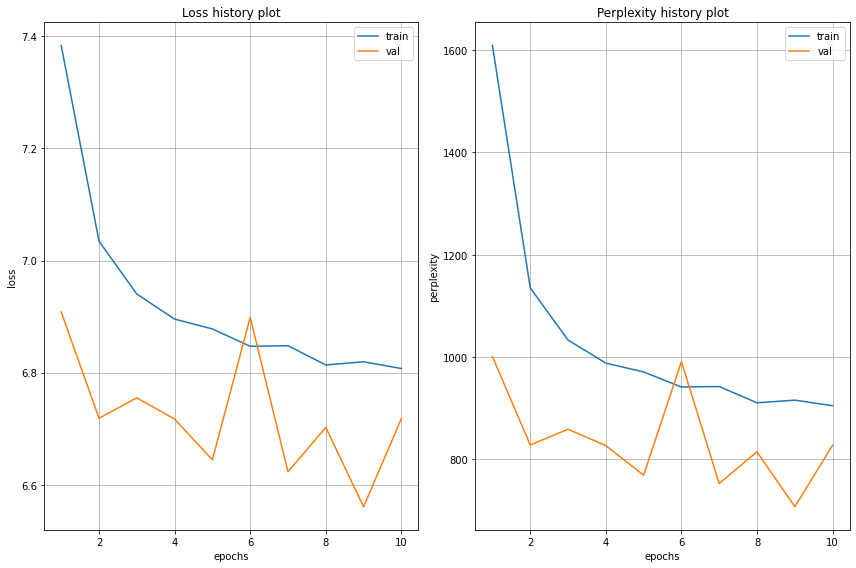

In [34]:
plot_hist(hist, name="baseline_hist_plot")


---

# 4 - Try to improve the model performance without using more resources.


Generally, to imrove performance with limited resources, we have following options to do:
- Improve data quality/quantity e.g. better preprocessing, better labeling, etc.
- Optimize hyperparameters
- Optimize resource-free model specifications e.g. optimizers, ...

<br>

What has been done:

- Change datasets' `seq_len` and `min_seq_len` to provide more information for MLM 
- Change `dropout` rate
- Add momentum to `SGD` optimizer
- Reducing LR scheduler's `gamma` rate

<br>

What more could be done:
- Add text cleaning steps to the data pipeline
- Use hyperparameter optimizization libraries to fin better hyperparams

In [67]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 40
eval_batch_size = 10
seq_len = 192

# Prepare the dataset
train_iter, valid_iter, test_iter = WikiText2(root='./data')
train_dataset = MaskedLMDataset(train_iter, tokenizer, vocab, seq_len, min_seq_len=10)
valid_dataset = MaskedLMDataset(valid_iter, tokenizer, vocab, seq_len, min_seq_len=10)
test_dataset = MaskedLMDataset(test_iter, tokenizer, vocab, seq_len, min_seq_len=10)

# Prepare the data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=eval_batch_size)
test_loader = DataLoader(test_dataset, batch_size=eval_batch_size)

In [74]:
ntokens = len(vocab)  # size of vocabulary
emsize = 200  # embedding dimension
d_hid = 200  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # number of heads in nn.MultiheadAttention
dropout = 0.2  # dropout probability
model_2 = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)

In [76]:
criterion = nn.CrossEntropyLoss(ignore_index= -100)
lr = 0.001  # learning rate
optimizer = torch.optim.SGD(model_2.parameters(), lr=lr, momentum=0.8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.9)

In [77]:
best_val_loss = float('inf')
epochs = 10

hist = {
    "loss":{
        "train":[],
        "val":[]
    },
    "perplexity":{
        "train":[],
        "val":[]
    }
}

with TemporaryDirectory() as tempdir:
    best_model2_params_path = os.path.join(tempdir, "best_model2_params.pt")

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train_loss = train(model_2)
        val_loss = evaluate(model_2, valid_loader)
        train_ppl = math.exp(train_loss)
        val_ppl = math.exp(val_loss)

        hist["loss"]["train"].append(train_loss)
        hist["loss"]["val"].append(val_loss)
        hist["perplexity"]["train"].append(train_ppl)
        hist["perplexity"]["val"].append(val_ppl)

        elapsed = time.time() - epoch_start_time
        print('-' * 89)
        print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
            f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
        print('-' * 89)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model_2.state_dict(), best_model2_params_path)

        scheduler.step()
    model_2.load_state_dict(torch.load(best_model2_params_path)) # load best model states

| epoch   1 |   200/  426 batches | lr 0.0010 | ms/batch 307.49 | loss  9.39 | ppl 11956.74
| epoch   1 |   400/  426 batches | lr 0.0010 | ms/batch 304.22 | loss  8.91 | ppl  7376.01
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 138.56s | valid loss  7.98 | valid ppl  2915.97
-----------------------------------------------------------------------------------------
| epoch   2 |   200/  426 batches | lr 0.0009 | ms/batch 305.38 | loss  8.14 | ppl  3433.28
| epoch   2 |   400/  426 batches | lr 0.0009 | ms/batch 304.14 | loss  8.06 | ppl  3179.14
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 138.17s | valid loss  7.70 | valid ppl  2210.13
-----------------------------------------------------------------------------------------
| epoch   3 |   200/  426 batches | lr 0.0008 | ms/batch 305.61 | loss  7.90 | ppl  2686.66
| epoch   3 |   400/  426 batc

In [78]:
test_loss = evaluate(model_2, test_loader)
test_ppl = math.exp(test_loss)
print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} | '
      f'test ppl {test_ppl:8.2f}')
print('=' * 89)

| End of training | test loss  7.28 | test ppl  1443.79


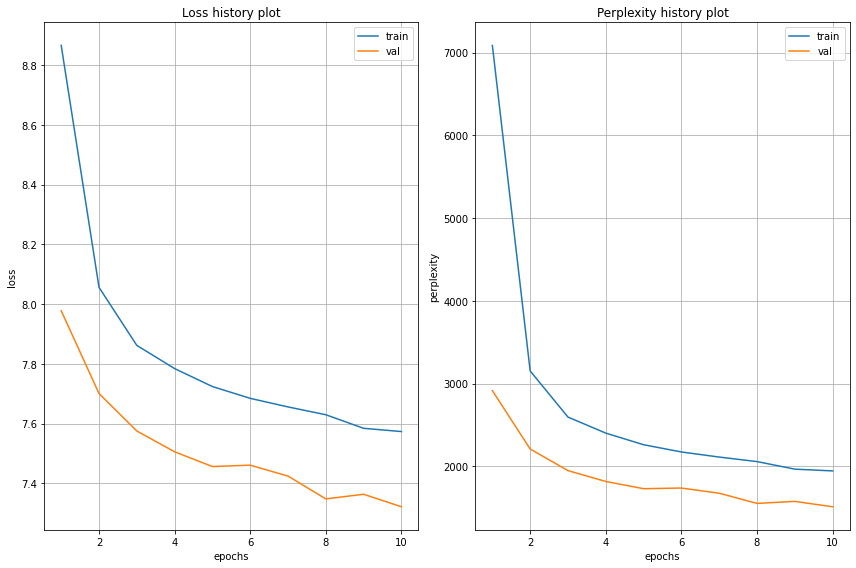

In [79]:
plot_hist(hist, name="improve_without_resources_hist_plot")

# 5- Improve the model without any restrictions. You can update architecture, hyper parameters etc.

What has been done:

- Increased number of **Attention heads**
- Expanded number of **hidden units** of Position-wise Feed-Forward Networks layers in transformers
- Added more attention block **layes**
- Increased **embedding size** of tokens


Also, kept the data improvements from section 4

In [81]:
ntokens = len(vocab)  # size of vocabulary
emsize = 512  # embedding dimension
d_hid = 1024  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 4  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 8  # number of heads in nn.MultiheadAttention
dropout = 0.15  # dropout probability
model_3 = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)

In [82]:
criterion = nn.CrossEntropyLoss(ignore_index= -100)
lr = 0.01  # learning rate
optimizer = torch.optim.SGD(model_3.parameters(), lr=lr, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.85)

In [83]:
best_val_loss = float('inf')
epochs = 10

hist = {
    "loss":{
        "train":[],
        "val":[]
    },
    "perplexity":{
        "train":[],
        "val":[]
    }
}                              
with TemporaryDirectory() as tempdir:
    best_model3_params_path = os.path.join(tempdir, "best_model3_params.pt")

    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train_loss = train(model_3)
        val_loss = evaluate(model_3, valid_loader)
        train_ppl = math.exp(train_loss)
        val_ppl = math.exp(val_loss)

        hist["loss"]["train"].append(train_loss)
        hist["loss"]["val"].append(val_loss)
        hist["perplexity"]["train"].append(train_ppl)
        hist["perplexity"]["val"].append(val_ppl)
        
        elapsed = time.time() - epoch_start_time
        print('-' * 89)
        print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
            f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
        print('-' * 89)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model_3.state_dict(), best_model3_params_path)

        scheduler.step()
    model_3.load_state_dict(torch.load(best_model3_params_path)) # load best model states

| epoch   1 |   200/  426 batches | lr 0.0100 | ms/batch 547.67 | loss  7.78 | ppl  2380.85
| epoch   1 |   400/  426 batches | lr 0.0100 | ms/batch 543.67 | loss  7.53 | ppl  1857.87
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 243.61s | valid loss  6.90 | valid ppl   990.79
-----------------------------------------------------------------------------------------
| epoch   2 |   200/  426 batches | lr 0.0085 | ms/batch 545.14 | loss  7.16 | ppl  1291.30
| epoch   2 |   400/  426 batches | lr 0.0085 | ms/batch 541.48 | loss  7.13 | ppl  1252.02
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 242.78s | valid loss  6.79 | valid ppl   889.87
-----------------------------------------------------------------------------------------
| epoch   3 |   200/  426 batches | lr 0.0072 | ms/batch 544.54 | loss  7.07 | ppl  1180.65
| epoch   3 |   400/  426 batc

In [84]:
test_loss = evaluate(model_3, test_loader)
test_ppl = math.exp(test_loss)
print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} | '
      f'test ppl {test_ppl:8.2f}')
print('=' * 89)

| End of training | test loss  6.59 | test ppl   725.42


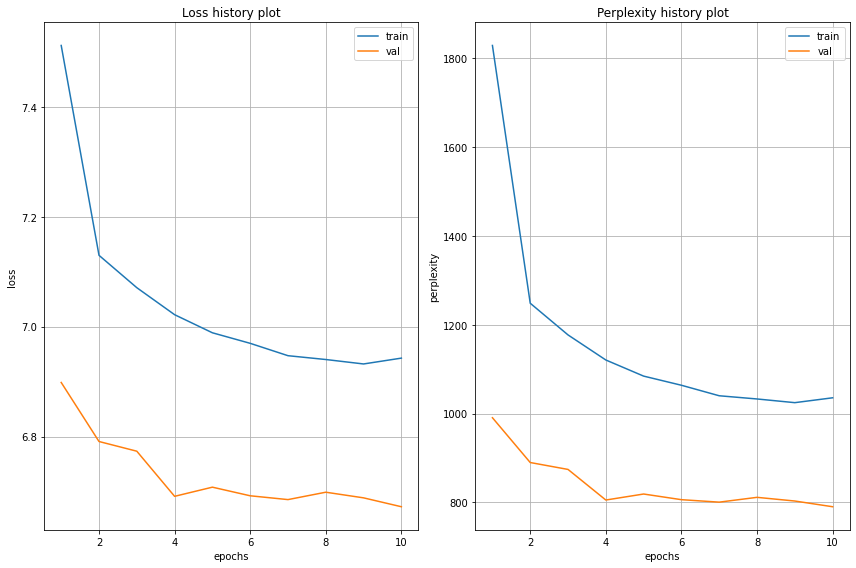

In [86]:
plot_hist(hist, name="improve_with_resources_hist_plot")

In [85]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()